<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Regressor_CPCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import csv
from sklearn.linear_model import LinearRegression 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error  
import os
import math
import cv2  
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/RAW/'  #change dir to your project folder


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
#Reading JPEGs and calculating trans, entropy, contrast
temp = os.listdir('/content/gdrive/My Drive/RAW/RAW_Batch1/')
jpg_names=[]
name_jpg=[]
dummy=[]
origin_time={}           #storing original timestamps 
#loading .jpg file names (ONLY Names) from RAW_Batch1
for name in temp: 
    path = '/content/gdrive/My Drive/RAW/RAW_Batch1/' + str(name)
    if(name.endswith('.jpg')):
      try: 
        name_jpg.append(path)
        dummy=name.split('_')
        k=str(dummy[3])+str(dummy[2])+str(dummy[1])+str(dummy[4])+str(dummy[5])
        jpg_names.append(k)
        origin_time[path]=k
      except: 
        print(name)

        
#JPEG IMAGES TIMESTAMPS GENERATED AS :         
print(origin_time)

{'/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_36_36_645.jpg': '150620191836', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_31_30_856.jpg': '150620191831', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_29_07_282.jpg': '150620191829', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_16_05_30_06_722.jpg': '160620190530', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_21_30_898.jpg': '150620191821', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_11_31_002.jpg': '150620191811', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_16_31_026.jpg': '150620191816', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_03_26_226.jpg': '150620191803', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_06_31_110.jpg': '150620191806', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_17_56_31_116.jpg': '150620191756', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_17_46_31_077.jpg': '15

In [5]:
#Enhancing JPEG timestamp and cpcb timestamp compatibility
mint=[]
for name in jpg_names:
  #print(name)
  mint.append(int(name[-2:]))

print(len(jpg_names))
print(len(mint))
new_mint=[]
for j in mint: 
  if(j<7.5):
    new_mint.append('00')
  elif(j<15 or j<22.5):
    new_mint.append('15')
  elif(j<30 or j<37.5):
    new_mint.append('30')
  elif(j<45 or j<52.5):
    new_mint.append('45')
  else:
    new_mint.append('00')

print(len(new_mint))


#compat has original jpeg timestamp corresponding to the new timestamp 
compat={}
k=0
for name in jpg_names:
  compat[name]=str(name[:-2])+str(new_mint[k])
  k+=1 
  
print(compat) 

714
714
714
{'150620191836': '150620191830', '150620191831': '150620191830', '150620191829': '150620191830', '160620190530': '160620190530', '150620191821': '150620191815', '150620191811': '150620191815', '150620191816': '150620191815', '150620191803': '150620191800', '150620191806': '150620191800', '150620191756': '150620191700', '150620191746': '150620191745', '150620191736': '150620191730', '150620191741': '150620191745', '150620191733': '150620191730', '140620191845': '140620191845', '150620191709': '150620191715', '150620191657': '150620191600', '140620191842': '140620191845', '140620191830': '140620191830', '150620191613': '150620191615', '140620191835': '140620191830', '150620191554': '150620191500', '140620190528': '140620190530', '140620191856': '140620191800', '140620190523': '140620190530', '120620191903': '120620191900', '140620191850': '140620191845', '120620191905': '120620191900', '120620191855': '120620191800', '120620191806': '120620191800', '110620191909': '1106201919

In [6]:
image_newtmp={}
for key in origin_time:
  for e in compat:
    if(origin_time[key]==e):
      image_newtmp[key]=compat[e]
      
print(len(image_newtmp))
print(image_newtmp)




714
{'/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_36_36_645.jpg': '150620191830', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_31_30_856.jpg': '150620191830', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_29_07_282.jpg': '150620191830', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_16_05_30_06_722.jpg': '160620190530', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_21_30_898.jpg': '150620191815', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_11_31_002.jpg': '150620191815', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_16_31_026.jpg': '150620191815', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_03_26_226.jpg': '150620191800', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_18_06_31_110.jpg': '150620191800', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_17_56_31_116.jpg': '150620191700', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_15_17_46_31_077.jpg':

In [0]:
def transmission(img, lt = 230, retMean = False):
  ker = np.ones((3, 3))/9.0
  imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  b, g, r = cv2.split(img)
  hsv = cv2.cvtColor(imgrgb, cv2.COLOR_RGB2HSV)
  _, _, v = cv2.split(hsv)
  v_blur = cv2.filter2D(v, -1, ker)
  _,building_mask = cv2.threshold(v_blur, lt, 255, cv2.THRESH_BINARY)
  sky = cv2.bitwise_and(imgrgb, imgrgb, mask = building_mask)
  sky_mask = cv2.bitwise_not(building_mask, building_mask.copy())
  building = cv2.bitwise_and(imgrgb, imgrgb, mask = sky_mask)
 
  al = max(v_blur.flatten())
  #Airlight Found. Now calculate Transmission Map
  img_norm = img/float(al)
  b, g, r = cv2.split(img_norm)
  kernel = np.ones((3,3),np.uint8)
  im_new = np.zeros((img.shape[0], img.shape[1]))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      im_new[i][j] = min(b[i][j], g[i][j], r[i][j])
  dcp = cv2.erode(im_new, kernel, iterations = 1)
  #ax[3].imshow(im_new, cmap = 'gray')
  #ax[4].imshow(dcp, cmap = 'gray')
  tr = np.ones((dcp.shape[0], dcp.shape[1]))
  for i in range(dcp.shape[0]):
    for j in range(dcp.shape[1]):
      tr[i][j] = 1 - dcp[i][j]
  #ax[1].imshow(tr, cmap = 'gray')
  if retMean == False:
    return tr
  elif retMean == True:
    return np.mean(tr)

In [0]:
def entropy(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  hist = cv2.calcHist( [image.astype('float32')],
              [0], 
              None,
               [256], 
              [0,256] )
  h_norm = 0
  h_norm = cv2.normalize(hist, h_norm)
  ent = 0
  for p in h_norm:
    try:
      ent += p*math.log(p, 2)
    except:
      pass
    
  return (-1 * ent[0])

In [0]:
def contrast(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  s = 0
  ss = 0
  mean = np.mean(image)
  x = (-1 * mean * (np.ones(image.shape)))
  ss = np.square(np.add(image, x))
  cont = np.sqrt(np.sum(ss)/float(image.size))
  return cont

In [11]:
#loading the cpcb csv
cpcb_time={}
k=0
with open('/content/cpcb_historic(11_16).csv') as cpcb: 
  reader=csv.reader(cpcb, delimiter = ',')
  for row in reader:
    k+=1
    if(k>=18):
      dummy=row[0]
      dummy=dummy.split('-')
      temp = dummy[2].split(' ')
      n = temp[1].split(':')
      dummy = str(dummy[0])+str(dummy[1])+str(temp[0]) + str(n[0]) + str(n[1])
      cpcb_time[dummy]=row[2]
      
      
print(cpcb_time)
print(len(cpcb_time))
      

{'110620190000': '122', '110620190015': '120', '110620190030': '118', '110620190045': '113', '110620190100': '110', '110620190115': '107', '110620190130': '102', '110620190145': '95', '110620190200': '89', '110620190215': '86', '110620190230': '87', '110620190245': '93', '110620190300': '99', '110620190315': '106', '110620190330': '113', '110620190345': '117', '110620190400': '122', '110620190415': '125', '110620190430': '128', '110620190445': '134', '110620190500': '140', '110620190515': '149', '110620190530': '159', '110620190545': '167', '110620190600': '173', '110620190615': '176', '110620190630': '178', '110620190645': '180', '110620190700': '181', '110620190715': '182', '110620190730': '186', '110620190745': '192', '110620190800': '201', '110620190815': '211', '110620190830': '219', '110620190845': '223', '110620190900': '230', '110620190915': '237', '110620190930': '245', '110620190945': '254', '110620191000': '256', '110620191015': '250', '110620191030': '235', '110620191045': 

In [12]:
#Matching modified JPEG images with their corresponding cpcb labels 
final_most = {}
for time in cpcb_time:
  for image in image_newtmp:
    if(image_newtmp[image]==time):
      final_most[image]=cpcb_time[time]

      
print(final_most)
print(len(final_most))




{'/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_11_18_57_32_569.jpg': '69', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_11_18_28_35_021.jpg': '72', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_11_18_34_35_794.jpg': '72', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_11_18_29_32_348.jpg': '72', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_11_18_49_32_353.jpg': '70', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_11_18_45_29_030.jpg': '70', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_11_18_39_46_198.jpg': '70', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_11_19_00_07_656.jpg': '69', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_11_19_07_06_983.jpg': '69', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_11_19_09_32_311.jpg': '68', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_11_19_14_32_358.jpg': '68', '/content/gdrive/My Drive/RAW/RAW_Batch1/JPEG_2019_06_12_05_56_38_280.jpg': '32', '/content/gdriv

In [13]:
final_time=[]

for key in final_most: 
  for img in image_newtmp:
    if(img==key):
      final_time.append(image_newtmp[key])
      
      
# print(len(final_time))
# print(final_time)
for i in range(0, len(final_time)):
  final_time[i]=int(final_time[i])
  
print(final_time)
print(len(final_time))

[110620191800, 110620191830, 110620191830, 110620191830, 110620191845, 110620191845, 110620191845, 110620191900, 110620191900, 110620191915, 110620191915, 120620190500, 120620190530, 120620190530, 120620190545, 120620190545, 120620190545, 120620190600, 120620190600, 120620190615, 120620190615, 120620190615, 120620190630, 120620190630, 120620190630, 120620190630, 120620190645, 120620190645, 120620190645, 120620190700, 120620190700, 120620190700, 120620190715, 120620190715, 120620190730, 120620190730, 120620190730, 120620190730, 120620190745, 120620190745, 120620190745, 120620190800, 120620190800, 120620190815, 120620190815, 120620190815, 120620190830, 120620190830, 120620190830, 120620190830, 120620190845, 120620190845, 120620190845, 120620190900, 120620190900, 120620190900, 120620190915, 120620190915, 120620190915, 120620190915, 120620190930, 120620190930, 120620190930, 120620190930, 120620190945, 120620190945, 120620191000, 120620191000, 120620191000, 120620191015, 120620191015, 12062

In [0]:
images=[]
j=0

labels=[]
for name in final_most:
  labels.append(final_most[name])
  try:
    read = cv2.imread(name)
    read = cv2.resize(read,(32,32))
    images.append(read)
    j+=1
    print(j)
  except:
    print(name)

print(len(images))
print(len(labels))

In [17]:
print(len(labels))

714


In [46]:
trans=[]
cont=[]
entropy_jpg=[]
for img in images:
  try:
    trans.append(transmission(img, retMean  = True))
    cont.append(contrast(img))
    entropy_jpg.append(entropy(img))
  except: 
    pass
    
print(trans)
print(len(trans))
print(cont)
print(len(cont))
print(entropy_jpg)
print(len(entropy_jpg))

[0.7510148590686275, 0.7146254595588235, 0.7258961397058824, 0.7139973958333334, 0.7358302696078431, 0.744006587009804, 0.7405215992647061, 0.7578546262254903, 0.755981924019608, 0.7673828125000001, 0.7771752450980393, 0.7185431985294117, 0.8578507965686274, 0.8565908394607843, 0.7346162683823529, 0.7410577512254903, 0.8153416053921568, 0.7110925099206349, 0.6393288352272728, 0.6637900684012875, 0.6809000651041666, 0.696385513117284, 0.6614130434782608, 0.6713909280711207, 0.6661748927038627, 0.6678685897435899, 0.6517973912444934, 0.6528780128923767, 0.6481955588400902, 0.6718315972222222, 0.6269803779069767, 0.6388056506849316, 0.635986328125, 0.6306846688646789, 0.651130850456621, 0.6497351844031531, 0.6346760321100917, 0.6323219686059908, 0.6690523917214912, 0.6727300347222223, 0.6620359167588495, 0.6777597402597403, 0.6704123072687225, 0.662567138671875, 0.6716385229820627, 0.6771510301438053, 0.6588805602477477, 0.6655470501681615, 0.6749529157366072, 0.6672276088169643, 0.678233

15.55786144073925
10.992853641456337


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


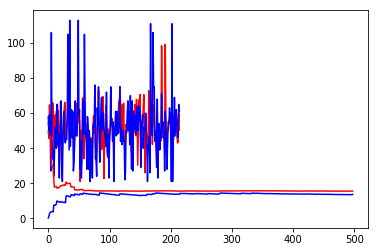

In [74]:
#feature engineering
for i in range(0,len(labels)):
  labels[i]=int(labels[i])
  
  
scaler = StandardScaler()  
final_time=np.reshape(final_time,(714,1))
trans=np.reshape(trans,(714,1))
cont=np.reshape(cont,(714,1))
entropy_jpg=np.reshape(entropy_jpg,(714,1))

#Standard scaling all the features 

final_time = scaler.fit_transform(final_time)
trans = scaler.fit_transform(trans)
cont = scaler.fit_transform(cont)
entropy_jpg = scaler.fit_transform(entropy_jpg)
features = np.hstack((final_time,trans, cont, entropy_jpg))

#Fitting regressor 
#reg = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize = False)

reg = SGDRegressor(penalty='elasticnet', max_iter=3000, random_state=24)

x_train, x_test, y_train , y_test = train_test_split(features, labels, test_size = 0.3, random_state = 42 )

x_trainclone = np.copy(x_train)
y_trainclone = np.copy(y_train)
reg.fit(x_train, y_train)

pred = reg.predict(x_test)

  
print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))

plt.plot(pred,"r-", label = 'predicted')
plt.plot(y_test, "b-", label = 'actual')


learning_curve(reg, features, labels)

In [0]:
def learning_curve(model, X, y):
  x_train, x_test, y_train , y_test = train_test_split(features, labels, test_size = 0.3, random_state = 42 )
  val_error=[]
  train_error=[]
  for m in range(1, len(x_train)):
    reg.fit(x_train[:m], y_train[:m])
    test_pred = reg.predict(x_test)
    train_pred = reg.predict(x_train[:m])
    val_error.append(np.sqrt(mean_squared_error(test_pred, y_test)))
    train_error.append(np.sqrt(mean_squared_error(train_pred , y_train[:m])))
    

  plt.plot(val_error,"r-" ,label = 'Validation error')
  plt.plot(train_error,"b-" ,label = 'train error ')
 

In [89]:
#relevant feature extraction 



param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
# reg = SGDRegressor(penalty='elasticnet',max_iter=1000)
reg = RandomForestRegressor()
grid_search = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid = grid_search.fit(x_trainclone, y_trainclone)



print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_sea)
#print(grid_search.cv_results_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
{'max_features': 3, 'n_estimators': 30}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [59]:
import pickle 
with open('/content/weather_data.bin', 'rb') as file:
  atad = pickle.load(file)

  
  

print(type(atad))
print(len(atad))
windspeed=[]
temp=[]
prec=[]
humidity=[]
pressure=[]
visibility=[]

values=atad.values
print(values)

# for j in values:
#   print(j)
#   print(j[0]['time'])
#   break
#   windspeed.append(j['time'][0])
#   temp.append(j[1])
#   prec.append(j[2])
#   humidity.append(j[4])
#   pressure.append(j[5])
#   visibility.append(j[6])

# print(len(windspeed))


# features = []
# i = 0
# j = 0
# for day in data.date:
#   print(i)
#   for hour in data.hourly[j]:
# #       if(int(time)<1000):
# #         time = '0' + time
#       year = day[0:4]
#       month =  day[5:7]
#       day1 = day[8:10]
#       time = hour["time"]
#       hourr = int(time)/100
#       if(hourr<10):
#         hour_s = '0' + str(hourr)
#       else:
#         hour_s = str(hourr)

#       if(i>0):
#         if(hourr==0):
#           hourr = 23
#           day1 = int(day1) - 1
#         else:
#           hourr = hourr - 1
#         if(hourr<10):
#           hour_s = '0' + str(hourr)
#         else:
#           hour_s = str(hourr)
          
#         if(int(day1)<10):
#           day1 = '0' + str(day1)
#         else:
#           day1 = str(day1)

         
#         features.append([(year+month+day1+hour_s[0:2]+"30"),(float(hour["windspeedKmph"]) + features[-1][1])/2,(float(hour["tempC"])+ features[-1][2])/2,(float(hour["precipMM"])+ features[-1][3])/2, (float(hour["HeatIndexC"])+ features[-1][4])/2, (float(hour["humidity"])+ features[-1][5])/2, (float(hour["pressure"])+ features[-1][6])/2, (float(hour["visibility"])+ features[-1][7])/2 ])

      
#       if(int(time)<1000):
#         time = '0' + time
#       year = day[0:4]
#       month =  day[5:7]
#       day1 = day[8:10]
#       #print(year+month+day)
#       i += 1
#       features.append([(year+month+day1+time[0:2]+"00"),float(hour["windspeedKmph"]),float(hour["tempC"]),float(hour["precipMM"]), float(hour["HeatIndexC"]), float(hour["humidity"]), float(hour["pressure"]), float(hour["visibility"]) ])
#   j+=1
# features

<class 'pandas.core.frame.DataFrame'>
9
[[list([{'sunrise': '05:23 AM', 'sunset': '07:19 PM', 'moonrise': '01:22 PM', 'moonset': '01:15 AM', 'moon_phase': 'First Quarter', 'moon_illumination': '59'}])
  '44' '112' '2019-06-11'
  list([{'time': '0', 'tempC': '44', 'tempF': '111', 'windspeedMiles': '8', 'windspeedKmph': '13', 'winddirDegree': '286', 'winddir16Point': 'WNW', 'weatherCode': '116', 'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.net/images/wsymbols01_png_64/wsymbol_0004_black_low_cloud.png'}], 'weatherDesc': [{'value': 'Partly cloudy'}], 'precipMM': '0.0', 'precipInches': '0.0', 'humidity': '8', 'visibility': '10', 'visibilityMiles': '6', 'pressure': '992', 'pressureInches': '30', 'cloudcover': '4', 'HeatIndexC': '46', 'HeatIndexF': '114', 'DewPointC': '2', 'DewPointF': '35', 'WindChillC': '44', 'WindChillF': '111', 'WindGustMiles': '10', 'WindGustKmph': '16', 'FeelsLikeC': '46', 'FeelsLikeF': '114', 'uvIndex': '0'}, {'time': '100', 'tempC': '43', 'tempF': '109'